# Cubic splines


## 1. Mathematical Formulation

Given a set of $n+1$ data points $(x_i, y_i)$ for $i = 0, 1, ..., n$, we want to find a cubic spline $S(x)$. This spline is composed of $n$ cubic polynomial pieces, $S_i(x)$, each defined over an interval $[x_i, x_{i+1}]$.

Each piece $S_i(x)$ has the form:

$$S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3$$

To ensure the overall curve $S(x)$ is a smooth interpolation, we enforce these conditions:

1.  **Interpolation**: Each piece must pass through its defining points.
    * $S_i(x_i) = y_i$
    * $S_i(x_{i+1}) = y_{i+1}$
2.  **Continuity**: The curve must be continuous at each interior knot.
    * $S_i(x_{i+1}) = S_{i+1}(x_{i+1})$ (this is actually covered by the interpolation condition).
3.  **First Derivative Continuity**: The slope (first derivative) must be continuous at each interior knot.
    * $S_i'(x_{i+1}) = S_{i+1}'(x_{i+1})$
4.  **Second Derivative Continuity**: The curvature (second derivative) must be continuous at each interior knot.
    * $S_i''(x_{i+1}) = S_{i+1}''(x_{i+1})$



## 2. Boundary Conditions

The choice of boundary conditions depends on the physical situation or the desired behavior of the spline at its ends.

Here are some common types:

1.  **Natural Spline**: This assumes the spline has zero curvature at the endpoints. It's like having a flexible ruler that extends straight beyond the first and last points. Mathematically:
    * $S_0''(x_0) = 0$
    * $S_{n-1}''(x_n) = 0$

2.  **Not-a-Knot Spline**: This condition forces the first and last two cubic pieces to be the *same* cubic polynomial. It makes the third derivative continuous at $x_1$ and $x_{n-1}$.

3.  **Clamped Spline**: Here, we specify the *slope* (first derivative) at the endpoints. This is useful if we know how the curve should start and end. In this case $f'(x_0)$ and $f'(x_n)$ are the desired slopes:
    * $S_0'(x_0) = f'(x_0)$
    * $S_{n-1}'(x_n) = f'(x_n)$

4.  **Periodic Spline**: Used for closed curves where the start and end points should smoothly connect. We require $y_0 = y_n$ and:
    * $S_0'(x_0) = S_{n-1}'(x_n)$
    * $S_0''(x_0) = S_{n-1}''(x_n)$


## 3. Python Implementation

Now, let's build a Python function to compute these splines:

In [1]:
import numpy as np
from scipy.linalg import solve_banded, solve
import matplotlib.pyplot as plt

class MyCubicSpline:
    """
    Computes cubic splines, mimicking the behavior of scipy's CubicSpline.
    """
    def __init__(self, x_pts, y_pts, bc_type='natural', bc_values=None):
        """
        Initializes the spline by computing coefficients.

        Args:
            x_pts (np.ndarray): Array of x-coordinates (must be sorted).
            y_pts (np.ndarray): Array of y-coordinates.
            bc_type (str): Type of boundary condition:
                           'natural', 'not-a-knot', 'clamped', 'periodic'.
            bc_values (tuple): Values for clamped BC (f'(x0), f'(xn)).
                               Required for 'clamped'.
        """

        # Verify the input data
        if not np.all(np.diff(x_pts) > 0):
            raise ValueError("x_pts must be strictly increasing.")
        if len(x_pts) != len(y_pts):
            raise ValueError("x_pts and y_pts must have the same length.")
        if len(x_pts) < 3 and bc_type == 'not-a-knot':
            raise ValueError("'not-a-knot' requires at least 4 points.")
        if bc_type == 'periodic' and not np.isclose(y_pts[0], y_pts[-1]):
            raise ValueError("A 'periodic' boundart condition implies y[0] == y[-1].")

        self.n = len(x_pts) - 1
        self.x = np.array(x_pts, dtype=float)
        self.y = np.array(y_pts, dtype=float)
        self.bc_type   = bc_type
        self.bc_values = bc_values

        # Step 1: Compute h_i
        self.h = np.diff(self.x)

        # Step 2: Set up the system A*c = vec_b
        A, vec_b = self._build_system_Ac_b()

        # Step 3: Solve for c_i
        #if self.bc_type in ['natural', 'clamped']:
        #    self.c = solve(A, vec_b, assume_a='tridiagonal')
        #elif self.bc_type in ['not-a-knot', 'periodic']:
        #    self.c = solve(A, vec_b, assume_a='banded')
        #else:
        #    raise ValueError(f'Unknown boundary condition type: {self.bc_type}')
        if self.bc_type == 'periodic':
            self.c         = np.empty(self.n+1)            
            self.c[:-1]    = solve(A, vec_b)
            self.c[self.n] = self.c[0]        # cn = c0
        else:
            self.c = solve(A, vec_b)

        # Step 4: Compute a_i, b_i, d_i
        self.a = self.y[:-1]
        self.b = (self.y[1:] - self.y[:-1])/self.h - (2*self.c[:-1] + self.c[1:])*self.h/3        
        self.d = (self.c[1:] - self.c[:-1])/(3*self.h)

        # Store coefficients for easy access if needed
        self.coeffs = {'a': self.a, 'b': self.b, 'c': self.c[:-1], 'd': self.d}


    def _build_system_Ac_b(self):
        """Builds the A matrix and vec_b vector based on BC type."""

        if self.bc_type == 'periodic':
            A     = np.zeros((self.n, self.n))
            vec_b = np.zeros(self.n)

            # Fill in the standard equations (rows 1 to n-2)
            for i in range(1, self.n-1):
                A[i, i-1] = self.h[i-1]
                A[i, i  ] = 2*(self.h[i-1] + self.h[i])
                A[i, i+1] = self.h[i]
                vec_b[i]  = 3*((self.y[i+1] - self.y[i]  )/self.h[i] - \
                               (self.y[i]   - self.y[i-1])/self.h[i-1])
        elif self.bc_type in ['natural', 'not-a-knot', 'clamped']:
            A     = np.zeros((self.n+1, self.n+1))
            vec_b = np.zeros(self.n+1)
            # Fill in the standard equations (rows 1 to n-1)
            for i in range(1, self.n):
                A[i, i-1] = self.h[i-1]
                A[i, i  ] = 2*(self.h[i-1] + self.h[i])
                A[i, i+1] = self.h[i]
                vec_b[i]  = 3*((self.y[i+1] - self.y[i]  )/self.h[i] - \
                               (self.y[i]   - self.y[i-1])/self.h[i-1])
        else:
            raise ValueError(f"Unknown boundary condition type: {self.bc_type}")

        # Apply Boundary Conditions
        if self.bc_type == 'natural':
            # First row
            A[     0,      0] = 1;       vec_b[     0] = 0

            # Last row
            A[self.n, self.n] = 1;       vec_b[self.n] = 0

        elif self.bc_type == 'clamped':
            if self.bc_values is None or len(self.bc_values) != 2:
                raise ValueError("bc_values (f'(x0), f'(xn)) must be provided for 'clamped'.")
            f_prime_0, f_prime_n = self.bc_values

            # First row
            A[0, 0]  = 2*self.h[0]
            A[0, 1]  = self.h[0]
            vec_b[0] = 3*((self.y[1] - self.y[0])/self.h[0] - f_prime_0)

            # Last row
            A[self.n, self.n-1] = self.h[self.n-1]
            A[self.n, self.n  ] = 2*self.h[self.n-1]
            vec_b[self.n]       = 3*(f_prime_n -  \
                                     (self.y[self.n] - self.y[self.n-1])/self.h[self.n-1])
        elif self.bc_type == 'not-a-knot':
            # First row
            A[0, 0]  = self.h[1]
            A[0, 1]  = -(self.h[0] + self.h[1])
            A[0, 2]  = self.h[0]
            vec_b[0] = 0

            # Last row
            A[self.n, self.n-2] = self.h[self.n-1]
            A[self.n, self.n-1] = -(self.h[self.n-2] + self.h[self.n-1])
            A[self.n, self.n]   = self.h[self.n-2]
            vec_b[self.n]       = 0

        elif self.bc_type == 'periodic':
            # First row:
            A[0, 0]         = 2*(self.h[self.n-1] + self.h[0])
            A[0, 1]         = self.h[0]
            A[0, self.n-1]  = self.h[self.n-1]
            vec_b[0]        = 3*((self.y[1] - self.y[0]       )/self.h[0] - \
                                 (self.y[0] - self.y[self.n-1])/self.h[self.n-1])

            # Last row:
            A[self.n-1,        0] = self.h[self.n-1]
            A[self.n-1, self.n-2] = self.h[self.n-2]
            A[self.n-1, self.n-1] = 2*(self.h[self.n-2] + self.h[self.n-1])
            vec_b[self.n-1]       = 3*((self.y[0]        - self.y[self.n-1])/self.h[self.n-1] - \
                                       (self.y[self.n-1] - self.y[self.n-2])/self.h[self.n-2])
            
            '''
            THIS ALSO WORKS Assuming that A and b have size n+1:
            # First row: c_0 = c_n => c_0 - c_n = 0
            A[0, 0] = 1
            A[0, self.n] = -1
            vec_b[0] = 0

            # Last row:
            # h_{n-1}c_{n-1} + 2(h_{n-1}+h_0)c_0 + h_0 c_1 = 3*((y_1-y_0)/h_0 - (y_0-y_{n-1})/h_{n-1})
            A[self.n, 0       ] = 2*(self.h[self.n-1] + self.h[0])
            A[self.n, 1       ] = self.h[0]
            A[self.n, self.n-1] = self.h[self.n-1]
            vec_b[self.n] = 3*((self.y[1]      - self.y[0]       )/self.h[0] - \
                               (self.y[self.n] - self.y[self.n-1])/self.h[self.n-1])
            '''
        return A, vec_b

    def __call__(self, x_eval):
        """
        Evaluates the spline at given x points.

        Args:
            x_eval (np.ndarray): Array of x-values to evaluate the spline.

        Returns:
            np.ndarray: Array of y-values corresponding to x_eval.
        """
        x_eval = np.array(x_eval, dtype=float)
        y_eval = np.zeros_like(x_eval)

        for i, x_val in enumerate(x_eval):
            # Find the correct interval
            # np.searchsorted finds the polynomial associated to x_val
            idx = np.searchsorted(self.x, x_val) - 1

            # Handle edge cases
            idx = np.clip(idx, 0, self.n-1)

            # Evaluate S_i(x) (TODO: implement Horner method)
            x_xi = x_val - self.x[idx]
            y_eval[i] = self.a[idx]         + \
                        self.b[idx]*x_xi    + \
                        self.c[idx]*x_xi**2 + \
                        self.d[idx]*x_xi**3

        return y_eval

## 4. Comparison with `scipy.interpolate.CubicSpline`

SciPy is a powerful library in Python for scientific and technical computing. It has a built-in `CubicSpline` function that is highly optimized and robust. Let's see how our My implementation compares.

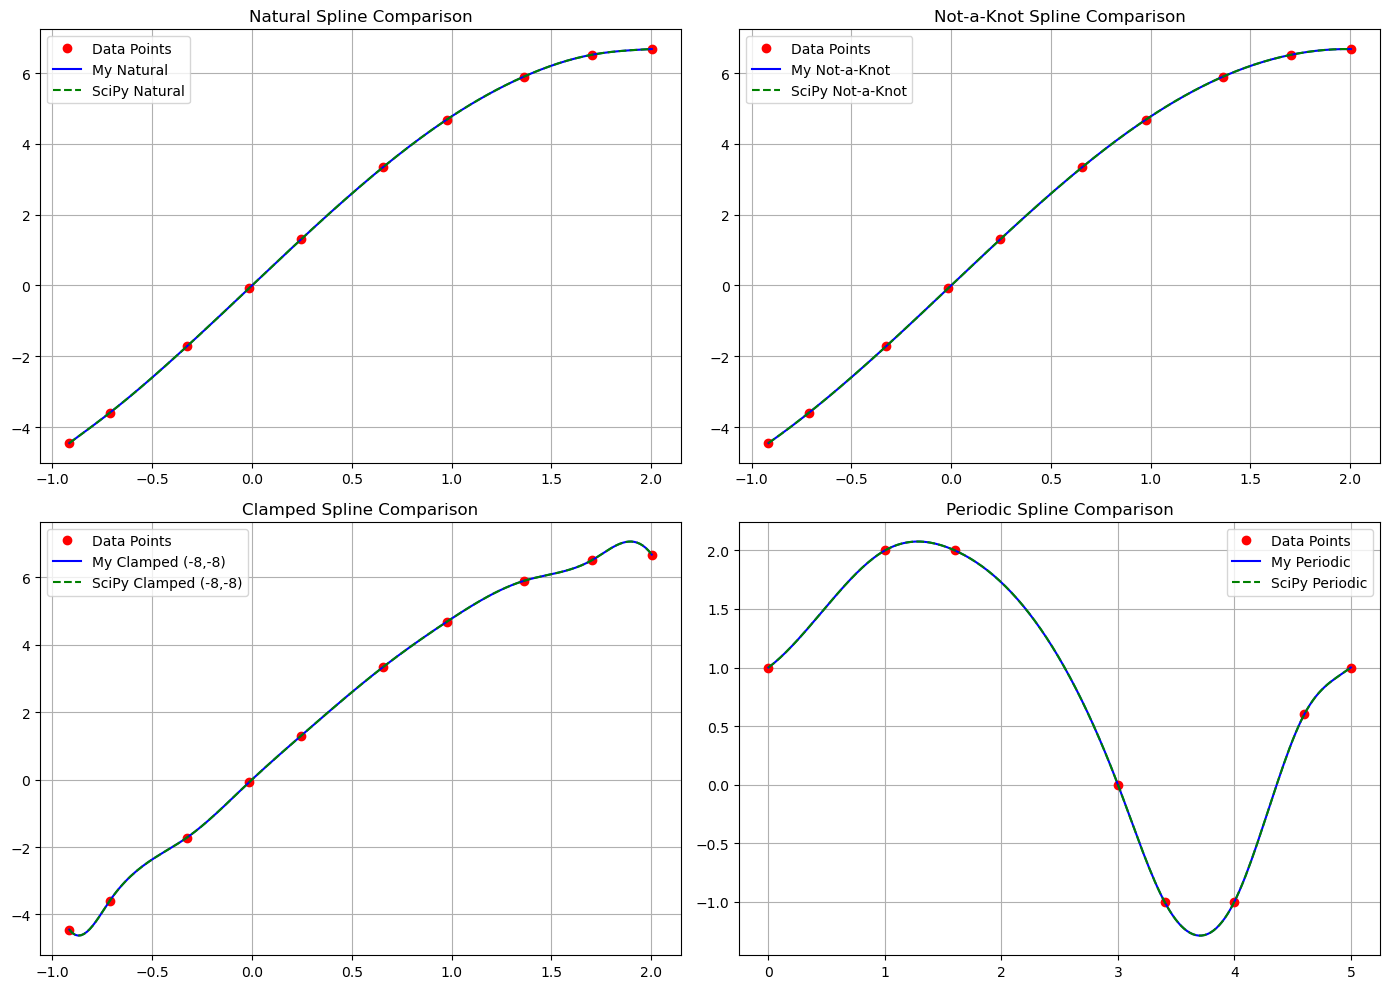


--- Max Differences ---
Natural:    1.78e-15
Not-a-Knot: 8.88e-16
Clamped:    1.78e-15
Periodic:   5.00e-16


In [2]:
from scipy.interpolate import CubicSpline

# --- Define some data points ---
# Example: A simple curve, with nonuniform spacing
x_points = np.sort(np.linspace(-1, 2, 10) + 0.05*np.random.randn(10))
y_points = 2*np.sin(x_points) + 5*np.sin(2*x_points/3)

# --- Generate points for plotting ---
x_plot = np.linspace(x_points[0], x_points[-1], 200)

# --- Test Cases ---
# 1. Natural Spline
my_natural   = MyCubicSpline(x_points, y_points, bc_type='natural')
sp_natural   = CubicSpline  (x_points, y_points, bc_type='natural')
y_my_natural = my_natural(x_plot)
y_sp_natural = sp_natural(x_plot)

# 2. Not-a-Knot Spline
my_nak   = MyCubicSpline(x_points, y_points, bc_type='not-a-knot')
sp_nak   = CubicSpline  (x_points, y_points, bc_type='not-a-knot')
y_my_nak = my_nak(x_plot)
y_sp_nak = sp_nak(x_plot)

# 3. Clamped Spline
fpx0 = -8  # slope at the beginning
fpxn = -8  # slope at the end
my_clamped = MyCubicSpline(x_points, y_points, bc_type='clamped', bc_values=(fpx0, fpxn))
sp_clamped = CubicSpline  (x_points, y_points, bc_type=((1, fpx0), (1, fpxn)))
#sp_clamped = CubicSpline  (x_points, y_points, bc_type='clamped') # = (0,0)

y_my_clamped = my_clamped(x_plot)
y_sp_clamped = sp_clamped(x_plot)

# 4. Periodic Spline (Needs periodic data)
x_periodic = np.array([0, 1, 1.6, 3, 3.4, 4, 4.6, 5])
y_periodic = np.array([1, 2, 2, 0, -1, -1, 0.6, 1]) # Ensure y[0] == y[-1]
x_plot_p   = np.linspace(x_periodic[0], x_periodic[-1], 200)

my_periodic   = MyCubicSpline(x_periodic, y_periodic, bc_type='periodic')
sp_periodic   = CubicSpline  (x_periodic, y_periodic, bc_type='periodic')
y_my_periodic = my_periodic(x_plot_p)
y_sp_periodic = sp_periodic(x_plot_p)


# --- Plotting ---
plt.figure(figsize=(14, 10))

# Natural
plt.subplot(2, 2, 1)
plt.plot(x_points, y_points,     'ro',  label='Data Points')
plt.plot(x_plot,   y_my_natural, 'b-',  label='My Natural')
plt.plot(x_plot,   y_sp_natural, 'g--', label='SciPy Natural')
plt.title('Natural Spline Comparison')
plt.legend()
plt.grid(True)

# Not-a-Knot
plt.subplot(2, 2, 2)
plt.plot(x_points, y_points, 'ro',  label='Data Points')
plt.plot(x_plot,   y_my_nak, 'b-',  label='My Not-a-Knot')
plt.plot(x_plot,   y_sp_nak, 'g--', label='SciPy Not-a-Knot')
plt.title('Not-a-Knot Spline Comparison')
plt.legend()
plt.grid(True)

# Clamped
plt.subplot(2, 2, 3)
plt.plot(x_points, y_points,   'ro',  label='Data Points')
plt.plot(x_plot, y_my_clamped, 'b-',  label=f'My Clamped ({fpx0},{fpxn})')
plt.plot(x_plot, y_sp_clamped, 'g--', label=f'SciPy Clamped ({fpx0},{fpxn})')
plt.title('Clamped Spline Comparison')
plt.legend()
plt.grid(True)

# Periodic
plt.subplot(2, 2, 4)
plt.plot(x_periodic, y_periodic,    'ro',  label='Data Points')
plt.plot(x_plot_p,   y_my_periodic, 'b-',  label='My Periodic')
plt.plot(x_plot_p,   y_sp_periodic, 'g--', label='SciPy Periodic')
plt.title('Periodic Spline Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Check differences ---
print("\n--- Max Differences ---")
print(f"Natural:    {np.max(np.abs(y_my_natural  - y_sp_natural)) :.2e}")
print(f"Not-a-Knot: {np.max(np.abs(y_my_nak      - y_sp_nak))     :.2e}")
print(f"Clamped:    {np.max(np.abs(y_my_clamped  - y_sp_clamped)) :.2e}")
print(f"Periodic:   {np.max(np.abs(y_my_periodic - y_sp_periodic)):.2e}")

### Discussion

When you run the code, you should see that the plots from our custom implementation and SciPy's `CubicSpline` overlap almost perfectly! The maximum differences should be very small (close to machine epsilon), indicating that our implementation correctly follows the mathematical theory.

* **Tridiagonal/Banded Solvers**: We used `solve_banded` for 'natural' and 'clamped' because they produce *tridiagonal* systems. This solver is generally faster and more memory-efficient than a general solver for large systems. For 'not-a-knot' and 'periodic', the system isn't strictly tridiagonal, so we used the general `solve`. SciPy likely employs highly optimized banded or sparse solvers internally for all cases.
* **Why Implement?**: You might wonder why we'd implement this if SciPy exists. Understanding the underlying algorithm (like you've done today!) is crucial for knowing *when* and *how* to use these tools effectively, how to interpret results, and how to adapt them if you encounter a non-standard problem.

# 5. CubicSpline with periodic boundary conditions for a closed curve:

When dealing with closed curves, standard cubic splines with natural or clamped boundary conditions often produce unsatisfactory results because they don't enforce continuity at the junction where the curve closes. This can lead to visible "kinks" or discontinuities that break the smoothness of the closed path.

## Periodic Boundary Conditions

Periodic cubic splines solve this problem by enforcing **periodicity conditions** at the boundaries:

1. **Function continuity**: $S(a) = S(b)$
2. **First derivative continuity**: $S'(a) = S'(b)$
3. **Second derivative continuity**: $S''(a) = S''(b)$

These conditions ensure that the spline function and its first two derivatives are continuous when wrapping around from the end back to the beginning of the parameter domain.

## Parametric Representation for Closed Curves

For closed curves in 2D or 3D space, we typically use a **parametric representation**:
- $x = x(t)$, $y = y(t)$ for parameter $t \in [a, b]$
- Each coordinate is interpolated separately using its own periodic cubic spline
- This ensures that both coordinates smoothly return to their starting values

This example will help you understand when and how to use periodic cubic splines effectively in your own applications involving closed curves or periodic data.

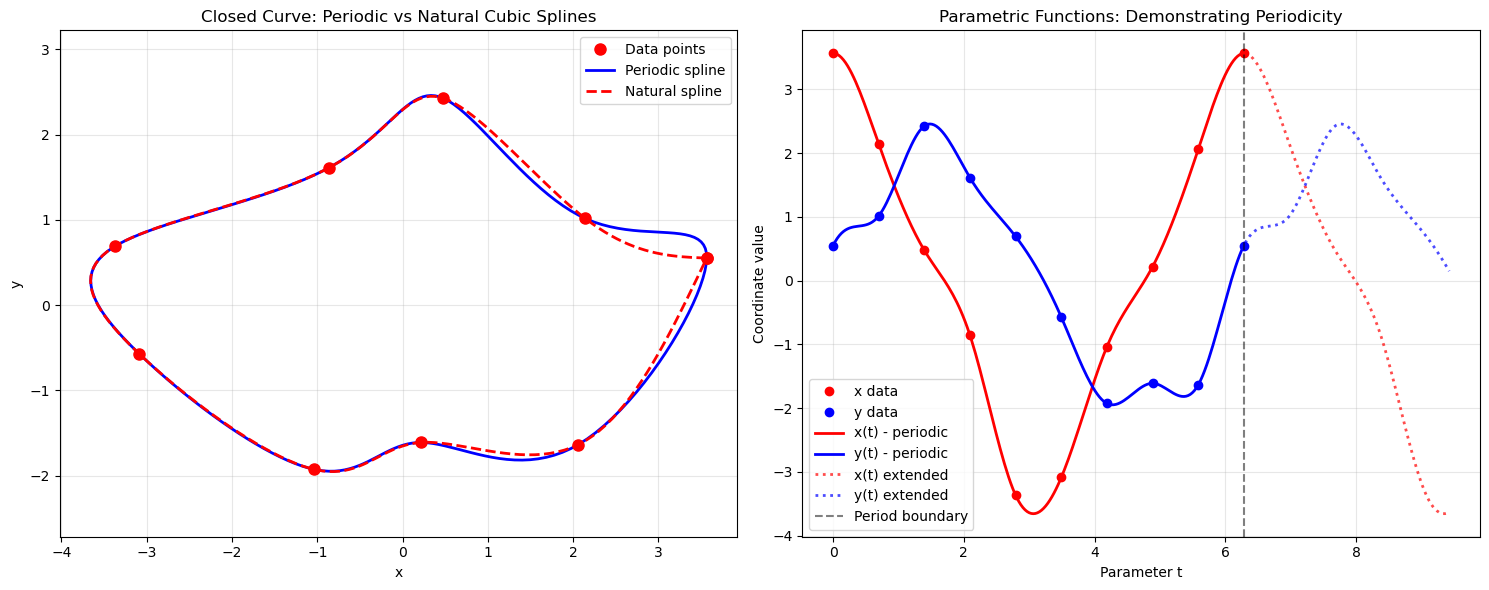


VERIFICATION OF PERIODIC BOUNDARY CONDITIONS
For periodic splines, all derivatives should match at the boundaries
x(0)   =   3.566637,  x(2π)   =   3.566637
y(0)   =   0.551329,  y(2π)   =   0.551329
x'(0)  =   0.040423,  x'(2π)  =   0.040423
y'(0)  =   2.069904,  y'(2π)  =   2.069904
x''(0) =  -9.439454,  x''(2π) =  -9.439454
y''(0) =  -9.896668,  y''(2π) =  -9.896668


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Create a closed curve dataset (e.g., an ellipse with some noise)
# We'll parametrize the curve with parameter t
# For periodic splines, we need the first and last points to be identical
t_data = np.linspace(0, 2*np.pi, 10)  # Base parameter values
x_data = 3*np.cos(t_data) + 0.5*np.cos(3*t_data) + 0.2*np.random.randn(len(t_data))
y_data = 2*np.sin(t_data) + 0.3*np.cos(5*t_data) + 0.2*np.random.randn(len(t_data))

# Make last point identical to first (for periodicity)
x_data[-1] = x_data[0]
y_data[-1] = y_data[0]

# Create periodic splines for both x and y coordinates
# Note: For a closed curve, we parametrize both x(t) and y(t) as functions of parameter t
sp_x_periodic = CubicSpline(t_data, x_data, bc_type='periodic')
sp_y_periodic = CubicSpline(t_data, y_data, bc_type='periodic')

# Create a finer grid for smooth visualization
t_fine     = np.linspace(0, 2*np.pi, 200)
x_periodic = sp_x_periodic(t_fine)
y_periodic = sp_y_periodic(t_fine)

# For comparison, create natural splines (non-periodic)
sp_x_natural = CubicSpline(t_data, x_data, bc_type='natural')
sp_y_natural = CubicSpline(t_data, y_data, bc_type='natural')
x_natural = sp_x_natural(t_fine)
y_natural = sp_y_natural(t_fine)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Comparison of periodic vs natural splines
ax1.plot(x_data,     y_data,     'ro',  markersize=8, label='Data points', zorder=3)
ax1.plot(x_periodic, y_periodic, 'b-',  linewidth=2,  label='Periodic spline')
ax1.plot(x_natural,  y_natural,  'r--', linewidth=2,  label='Natural spline')

# Close the curves for visualization (not needed for periodic spline)
ax1.plot([x_natural[-1], x_natural[0]], [y_natural[-1], y_natural[0]], 'r--', linewidth=2)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Closed Curve: Periodic vs Natural Cubic Splines')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# Plot 2: Demonstrate continuity of derivatives at the boundary
# Show the parametric functions x(t) and y(t)
ax2.plot(t_data, x_data,     'ro', markersize=6, label='x data')
ax2.plot(t_data, y_data,     'bo', markersize=6, label='y data')
ax2.plot(t_fine, x_periodic, 'r-', linewidth=2,  label='x(t) - periodic')
ax2.plot(t_fine, y_periodic, 'b-', linewidth=2,  label='y(t) - periodic')

# Show periodicity by extending the domain
t_extended = np.linspace(0, 3*np.pi, 300)
x_extended = sp_x_periodic(t_extended)
y_extended = sp_y_periodic(t_extended)
ax2.plot(t_extended[200:], x_extended[200:], 'r:', linewidth=2, alpha=0.7, label='x(t) extended')
ax2.plot(t_extended[200:], y_extended[200:], 'b:', linewidth=2, alpha=0.7, label='y(t) extended')

ax2.axvline(x=2*np.pi, color='k', linestyle='--', alpha=0.5, label='Period boundary')
ax2.set_xlabel('Parameter t')
ax2.set_ylabel('Coordinate value')
ax2.set_title('Parametric Functions: Demonstrating Periodicity')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Verify periodicity conditions
print("\n" + "="*70)
print("VERIFICATION OF PERIODIC BOUNDARY CONDITIONS")
print("For periodic splines, all derivatives should match at the boundaries")
print("="*70)

# Check function values at boundaries
print(f"x(0)   = {sp_x_periodic(0)   : 10.6f},  x(2π)   = {sp_x_periodic(2*np.pi)   : 10.6f}")
print(f"y(0)   = {sp_y_periodic(0)   : 10.6f},  y(2π)   = {sp_y_periodic(2*np.pi)   : 10.6f}")

# Check first derivatives at boundaries
print(f"x'(0)  = {sp_x_periodic(0, 1): 10.6f},  x'(2π)  = {sp_x_periodic(2*np.pi, 1): 10.6f}")
print(f"y'(0)  = {sp_y_periodic(0, 1): 10.6f},  y'(2π)  = {sp_y_periodic(2*np.pi, 1): 10.6f}")

# Check second derivatives at boundaries
print(f"x''(0) = {sp_x_periodic(0, 2): 10.6f},  x''(2π) = {sp_x_periodic(2*np.pi, 2): 10.6f}")
print(f"y''(0) = {sp_y_periodic(0, 2): 10.6f},  y''(2π) = {sp_y_periodic(2*np.pi, 2): 10.6f}")